# Diffusion-based, combining item-item and user-user

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
import re
import os
from itertools import permutations

import networkx as nx
from networkx.algorithms import bipartite

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from tqdm import tqdm

In [2]:
df_movies = pd.read_csv('data/movies.dat',
                        delimiter='::', engine= 'python', encoding='ISO-8859-1', header=None,
                        names=['movie_id', 'movie_name', 'genre'])

df_users = pd.read_csv('data/users.dat',
                       delimiter='::', engine='python',  encoding='ISO-8859-1',header=None,
                       names=['user_id', 'gender', 'age', 'occupation', 'zip_code'])

df_ratings = pd.read_csv('data/ratings.dat',
                         delimiter='::', engine='python',  encoding='ISO-8859-1',header=None,
                         names=['user_id', 'movie_id', 'rating', 'time'])

In [3]:
df_movies['year'] = df_movies.movie_name.apply(lambda x: re.findall(r'\(\d{4}\)', x)[0][1:-1])
df_ratings.drop(columns=['time'], inplace=True)

In [4]:
df_movies.head()

,movie_id,movie_name,genre,year
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [5]:
df_users.head()

,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [6]:
df_ratings.head()

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


### Deal with user metadata

Add region classification

In [7]:
df_users.zip_code = df_users.zip_code.apply(lambda x: x.split('-')[0]).astype(int)

In [8]:
df_users = pd.merge(df_users, pd.read_csv('data/zip_code_database.csv'), how='left', left_on='zip_code', right_on='zip')
df_users.drop(
    columns=['decommissioned', 'primary_city', 'acceptable_cities', 'unacceptable_cities', 
             'type', 'zip', 'county', 'timezone', 'area_codes', 'world_region', 'country', 
             'latitude', 'longitude'],
    inplace=True)

In [9]:
df_users.dropna(inplace=True)

In [10]:
census_region_mapping = {
    'WEST': ['WA', 'OR', 'CA', 'NV', 'ID', 'MT', 'WY', 'UT', 'CO', 'HI', 'AK', 'NM', 'AZ'],
    'SOUTH': ['TX', 'OK', 'AR', 'LA', 'KY', 'TN', 'MS', 'AL', 'WV', 
              'VA', 'DC', 'DE', 'MD', 'NC', 'SC', 'GA', 'FL', 'PR'],
    'MIDWEST': ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'MI', 'IN', 'OH'],
    'NORTHEAST': ['PA', 'NY', 'NJ', 'RI', 'CT', 'MA', 'NH', 'VT', 'ME']
}

def match_region(state: str) -> str:
    for k, v in census_region_mapping.items():
        if state in v:
            return k
    return state

In [11]:
df_users['region'] = df_users.state.apply(match_region)

In [12]:
df_users.isna().sum()

user_id                     0
gender                      0
age                         0
occupation                  0
zip_code                    0
state                       0
irs_estimated_population    0
region                      0
dtype: int64

Convert population to categorical

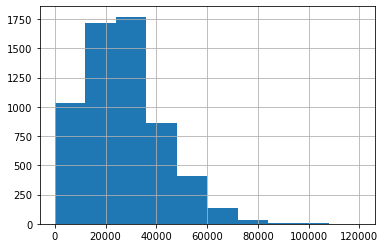

In [13]:
_ = df_users.irs_estimated_population.hist(bins=10)

In [14]:
population_bins = [0, 15000, 20000, 30000, 35000, 40000, 60000, 150000]
population_labels = [1, 2, 3, 4, 5, 6, 7]
df_users['population'] = pd.cut(df_users.irs_estimated_population, bins=population_bins, labels=population_labels)

### Merge item user data and split into train and test data

In [15]:
# get rid of ratings with no zip information
df_ratings = df_ratings[df_ratings.user_id.isin(df_users.user_id)]
# reduce movies to those only exist in ratings
df_movies = df_movies[df_movies.movie_id.isin(df_ratings.movie_id)]

In [16]:
df_ratings_train_temp, df_ratings_test_temp = train_test_split(df_ratings, test_size=0.2, random_state=42)

In [17]:
df_ratings_train = df_ratings.copy()
df_ratings_test = df_ratings.copy()

In [18]:
df_ratings_train.loc[df_ratings_test_temp.index, 'rating'] = 0
df_ratings_test.loc[df_ratings_train_temp.index, 'rating'] = 0

In [19]:
df_ratings_train_mat = pd.pivot(df_ratings_train, index='user_id', columns='movie_id', values='rating').fillna(0).to_numpy()
df_ratings_test_mat = pd.pivot(df_ratings_test, index='user_id', columns='movie_id', values='rating').fillna(0).to_numpy()

In [20]:
df_ratings_train_mat.shape

(5972, 3705)

In [21]:
df_ratings_test_mat.shape

(5972, 3705)

In [22]:
N_users, N_movies = df_ratings_train_mat.shape

### Generate similarity matrix

In [23]:
genres = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama',
          'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

In [24]:
def genre_to_arr(genres_str: str) -> np.array:
    gs = genres_str.split('|')
    genres_arr = np.zeros(len(genres))
    for i, g in enumerate(genres):
        if g in gs:
            genres_arr[i] = 1
    return genres_arr

In [25]:
def gen_sim_mat(df: pd.DataFrame, feature: str, cat: str, is_genre=False) -> np.array:
    id_col = cat + '_id'
    N = len(df)
    
    if is_genre:
        pivot_feature = np.array(df[feature].apply(genre_to_arr).tolist())
    else:
        temp = pd.concat([df, pd.DataFrame({'exist': [1] * len(df)}, index=df.index)], axis=1)
        pivot_feature = pd.pivot(temp, index=id_col, columns=feature, values='exist').fillna(0)
    
    sim = np.ones((N, N)) - pairwise_distances(pivot_feature, metric='cosine')
    return sim

Movie feature

In [26]:
movie_movie_similarity = np.ones((N_movies, N_movies)) - pairwise_distances(df_ratings_train_mat.T, metric='cosine')
movie_movie_similarity.shape

(3705, 3705)

In [27]:
year_similarity = gen_sim_mat(df_movies, 'year', 'movie')
year_similarity.shape

(3705, 3705)

In [28]:
genre_similarity = gen_sim_mat(df_movies, 'genre', 'movie', True)
genre_similarity.shape

(3705, 3705)

User feature

In [29]:
user_user_similarity = np.ones((N_users, N_users)) - pairwise_distances(df_ratings_train_mat, metric='cosine')
user_user_similarity.shape

(5972, 5972)

In [30]:
occupation_similarity = gen_sim_mat(df_users, 'occupation', 'user')
occupation_similarity.shape

(5972, 5972)

In [31]:
age_similarity = gen_sim_mat(df_users, 'age', 'user')
age_similarity.shape

(5972, 5972)

In [32]:
region_similarity = gen_sim_mat(df_users, 'region', 'user')
region_similarity.shape

(5972, 5972)

In [33]:
population_similarity = gen_sim_mat(df_users, 'population', 'user')
population_similarity.shape

(5972, 5972)

Bipartite features

In [34]:
if 'B_similarity_movies.csv' in os.listdir():
    B_similarity_movies = pd.read_csv("B_similarity_movies.csv")
    B_similarity_movies = np.array(B_similarity_movies.drop('Unnamed: 0', axis=1))
else:
    users_str = np.array([str(uid) for uid in df_users.user_id.unique()])
    df_ratings['user_id_str'] = df_ratings['user_id'].apply(str)
    
    g = nx.Graph()
    g.add_nodes_from(users_str, bipartite=0)
    g.add_nodes_from(df_movies.movie_id, bipartite=1)

    edges = df_ratings[['user_id_str', 'movie_id']].values
    g.add_edges_from(edges)

    B = bipartite.overlap_weighted_projected_graph(g, df_movies.movie_id)
    B_edges = list(B.edges(data=True))
    
    movie_id_to_index = dict(zip(df_movies.movie_id.tolist(), np.arange(N_movies)))
    
    B_similarity_movies = np.zeros((N_movies, N_movies))
    
    for i, j, weight in tqdm(B_edges):
        i = movie_id_to_index[i]
        j = movie_id_to_index[j]
        B_similarity_movies[i, j] = weight['weight']
        B_similarity_movies[j, i] = weight['weight']
        
    pd.DataFrame(B_similarity_movies).to_csv("B_similarity_movies.csv")

100%|█████████████████████████████████████████| 5647256/5647256 [00:05<00:00, 959173.05it/s]


In [35]:
if 'B_similarity_users.csv' in os.listdir():
    B_similarity_users = pd.read_csv("B_similarity_users.csv")
    B_similarity_users = np.array(B_similarity_users.drop('Unnamed: 0', axis=1))
else:
    movies_str = np.array([str(mid) for mid in df_movies.movie_id.unique()])
    df_ratings['movie_id_str'] = df_ratings.movie_id.apply(str)
    
    g = nx.Graph()
    g.add_nodes_from(movies_str, bipartite=0)
    g.add_nodes_from(df_users.user_id, bipartite=1)

    edges = df_ratings[['movie_id_str', 'user_id']].values
    g.add_edges_from(edges)

    B = bipartite.overlap_weighted_projected_graph(g, df_users.user_id)
    B_edges = list(B.edges(data=True))
    
    user_id_to_index = dict(zip(df_users.user_id.tolist(), np.arange(N_users)))
    
    B_similarity_users = np.zeros((N_users, N_users))
    
    for i, j, weight in tqdm(B_edges):
        i = user_id_to_index[i]
        j = user_id_to_index[j]
        B_similarity_users[i, j] = weight['weight']
        B_similarity_users[j, i] = weight['weight']
        
    pd.DataFrame(B_similarity_users).to_csv("B_similarity_users.csv")

100%|███████████████████████████████████████| 17083620/17083620 [00:18<00:00, 900700.85it/s]


### Transition matrix

In [36]:
def feature_to_transition(feature_sim: np.array) -> np.array:
    return feature_sim / feature_sim.sum(axis=1)

Movie feature

In [37]:
movie_movie_tm = feature_to_transition(movie_movie_similarity)
year_tm = feature_to_transition(year_similarity)
genre_tm = feature_to_transition(genre_similarity)
movie_B_tm = feature_to_transition(B_similarity_movies)

User feature

In [38]:
user_user_tm = feature_to_transition(user_user_similarity)
occupation_tm = feature_to_transition(occupation_similarity)
age_tm = feature_to_transition(age_similarity)
region_tm = feature_to_transition(region_similarity)
population_tm = feature_to_transition(population_similarity)
user_B_tm = feature_to_transition(B_similarity_users)

### Prediction

In [39]:
scaler = MinMaxScaler()

In [40]:
def random_walk_predict(ratings: np.array, transition_matrix: np.array, alpha: float) -> np.array:
    x = np.eye(transition_matrix.shape[0]) - alpha * transition_matrix
    #Obtain mean of columns as you need, nanmean is convenient.
    col_mean = np.nanmean(x, axis=0)
    #Find indices that you need to replace
    inds = np.where(np.isnan(x))
    #Place column means in the indices. Align the arrays using take
    x[inds] = np.take(col_mean, inds[1])
    # GPU does not perform well on pinv function
    p_tilde = np.linalg.pinv(x)    
    final_rating = alpha * np.dot(ratings, np.dot(x, p_tilde))
    
    final_rating[final_rating < 0] = 0
    neglog_final_rating = 0 - np.log10(final_rating, out=np.zeros_like(final_rating), where=(final_rating != 0))
    scaled_prediction = (scaler.fit_transform(neglog_final_rating.T) * 5).T
    
    return scaled_prediction

In [77]:
def rmse(prediction: np.array, test_data_matrix: np.array, item=True) -> float:
    if item:
        mask = test_data_matrix.nonzero()
        truth = test_data_matrix[mask].flatten()
    else:
        mask = test_data_matrix.T.nonzero()
        truth = test_data_matrix.T[mask].flatten()
        
    prediction = prediction[mask].flatten()
    return sqrt(mean_squared_error(prediction, truth))

In [75]:
def run_grid_search(parameters: list, item=True) -> dict:
    results = {}
    for parameter in tqdm(parameters):
        if item: 
            alpha, beta, w1, w2, w3, w4 = parameter
            transition_matrix = beta * (w1 * movie_movie_tm + w2 * year_tm + w3 * movie_B_tm + 
                                        w4 * genre_tm) + (1 - beta) / N_movies
            prediction = random_walk_predict(df_ratings_train_mat, transition_matrix, alpha)
        else:
            alpha, beta, w1, w2, w3, w4, w5 = parameter
            transition_matrix = beta * (w1 * user_user_tm + w2 * population_tm + w3 * age_tm
                                        + w4 * region_similarity 
                                        + w5 * occupation_similarity) + (1 - beta) / N_users
            prediction = random_walk_predict(df_ratings_train_mat.T, transition_matrix, alpha)
            
        results[parameter] = rmse(prediction, df_ratings_test_mat, item)

    return results

In [58]:
def generate_parameters(item=True) -> list:
    cs = [0.6, 0.7, 0.8]
    coeffs = list(permutations(cs, 2))
    ws = [0.1, 0.15, 0.2, 0.25, 0.3]
    if item:
        weights = list(permutations(ws, 4))
    else:
        weights = list(permutations(ws, 5))
    
    return [x + y for x in coeffs for y in weights] + [y + x for x in coeffs for y in weights]

Item-Item predict

In [80]:
parameters_ii = generate_parameters(True)

In [ ]:
results_ii = run_grid_search(parameters_ii)

User-User predict

In [81]:
parameters_uu = generate_parameters(False)

In [ ]:
results_uu = run_grid_search(parameters_uu, False)

In [82]:
def get_min(results: dict) -> None:
    print(min(results, key=results.get), results[min(results, key=results.get)])

In [62]:
pd.DataFrame({"key": results_uu.keys(), "values": results_uu.values()}).to_csv("results_uu.csv", index=False)
pd.DataFrame({"key": results_ii.keys(), "values": results_ii.values()}).to_csv("results_ii.csv", index=False)

### Some test on code

In [136]:
alpha, beta, w1, w2, w3 = 0.7, 0.6, 0.2, 0.4, 0.1
transition_matrix = beta * (w1 * movie_movie_tm + w2 * year_tm + w3 * movie_B_tm + 
                                    (1 - w1 - w2 - w3) * genre_tm) + (1 - beta) / N_movies

In [302]:
alpha, beta, w1, w2, w3, w4 = 0.7, 0.6, 0.2, 0.1, 0.2, 0.2
transition_matrix = beta * (w1 * user_user_tm + w2 * population_tm + w3 * age_tm + w4 * region_similarity + 
                                    (1 - w1 - w2 - w3 - w4) * occupation_similarity) + (1 - beta) / N_users

In [303]:
t = random_walk_predict(df_ratings_train_mat.T, transition_matrix, alpha)

[[ 3.50000000e+00  5.26684913e-12 -6.66871991e-12 ...  5.45989655e-13
   1.04531174e-12  5.74499426e-13]
 [-6.62618095e-13  1.62925203e-12 -1.93413607e-12 ...  1.59473441e-13
   2.55853151e-13  1.38250704e-13]
 [-5.20352601e-13  1.14938293e-12 -8.10154904e-13 ...  7.41419079e-14
  -1.69115660e-13 -1.62303524e-13]
 ...
 [-9.86490403e-14  1.97201392e-13 -2.21374134e-14 ...  6.25974966e-15
  -5.17798478e-14 -3.94489739e-14]
 [-4.12014932e-14  2.57218032e-13 -1.26068080e-13 ...  5.59066682e-15
  -1.17256465e-14  1.75527995e-15]
 [-4.40975685e-13  8.87607267e-13 -1.17479682e-12 ...  7.99107007e-14
   4.01836388e-14 -1.36909635e-14]]


In [304]:
t[t<0] = 0

In [305]:
neglog_t = 0 - np.log10(t, out=np.zeros_like(t), where=(t!=0))

(array([11440361.,        0.,        0.,        0.,        0.,        0.,
           85918.,  5240354.,  4999586.,   360041.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

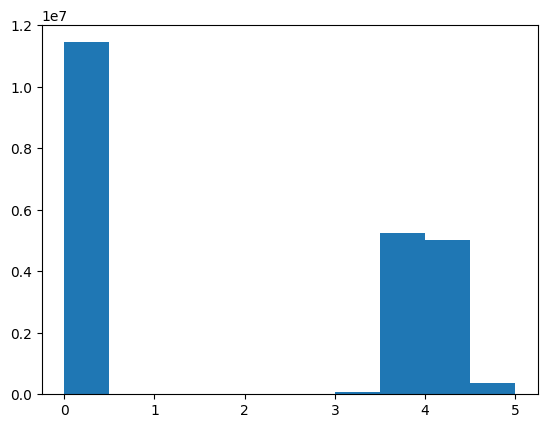

In [306]:
plt.hist(scaler.fit_transform(neglog_t).flatten() * 5)

(array([14023.,     0., 26548.,     0.,     0., 64909.,     0., 86414.,
            0., 55572.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

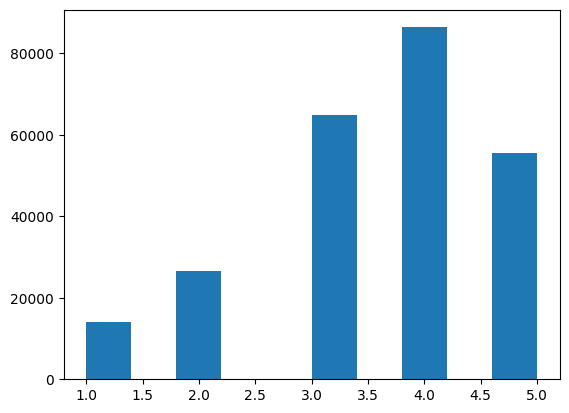

In [301]:
plt.hist(df_ratings_test_mat[df_ratings_test_mat.nonzero()].flatten())